In [1]:
import pandas as pd
import numpy as np
data=pd.read_csv("IMDB Dataset.csv",sep=",")
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Quantifying the sentiment to column 

In [2]:
target=[]
for i in data["sentiment"]:
    if i=="positive":
        target.append(1)
    else:
        target.append(-1)
target=np.array(target)

Lower casing every later, removing stopwords and punctuation

In [3]:
from textblob import TextBlob
import re
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
stop = stopwords.words('english')
def preprocessor(doc):
    doc = re.sub("<[^>]*>", "", doc)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', doc)
    doc = (re.sub("[\W]+", " ", doc.lower()) + " " .join(emoticons).replace('-', ''))

    ret_text = ""
    for word in doc.split():
        if word not in stop:
            ret_text += word + " "

    ret_text = ret_text.strip()

    if len(ret_text) == 0:
        ret_text = "Invalid"
    return ret_text
data["cleaned text"]=data["review"].apply(preprocessor)
x=data["cleaned text"]
x

<>:9: SyntaxWarning: invalid escape sequence '\)'
<>:10: SyntaxWarning: invalid escape sequence '\W'
<>:9: SyntaxWarning: invalid escape sequence '\)'
<>:10: SyntaxWarning: invalid escape sequence '\W'
C:\Users\giorg\AppData\Local\Temp\ipykernel_6104\772322271.py:9: SyntaxWarning: invalid escape sequence '\)'
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', doc)
C:\Users\giorg\AppData\Local\Temp\ipykernel_6104\772322271.py:10: SyntaxWarning: invalid escape sequence '\W'
  doc = (re.sub("[\W]+", " ", doc.lower()) + " " .join(emoticons).replace('-', ''))


0        one reviewers mentioned watching 1 oz episode ...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake thinks zombie...
4        petter mattei love time money visually stunnin...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    going disagree previous comment side maltin on...
49999    one expects star trek movies high art fans exp...
Name: cleaned text, Length: 50000, dtype: object

Let's split the dataset into the training and testing set and write a function which returns the polarity score of TextBlob

In [4]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,target,test_size=0.3,random_state=1,stratify=target)
def analyzer(x):
    analysis=[]
    for text in x:
        blob=TextBlob(text)
        sentiment=blob.sentiment
        analysis.append(sentiment)
    analysis=pd.DataFrame(analysis)
    return np.array(analysis["polarity"]).reshape(-1,1)

    

I am using Logistic Regression as my classifier

In [5]:
from sklearn.linear_model import LogisticRegression
cl=LogisticRegression(solver="liblinear",n_jobs=-1)
cl.fit(analyzer(x_train),y_train)
pred=cl.predict(analyzer(x_test))


Printing the measures of the classifier as a dataframe

In [6]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred)
prec=precision_score(y_test,pred)
recall=recall_score(y_test,pred)
results=[]
results.append((acc,f1,prec,recall))
results=pd.DataFrame(results,columns=["Accuracy","F1-Score","Precision","Recall"])
results

,Accuracy,F1-Score,Precision,Recall
0,0.762733,0.764258,0.759379,0.7692


The confusion matrix of the classification

In [7]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred))

[[5672 1828]
 [1731 5769]]


In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred, target_names={"Positive", "Negative"}))

              precision    recall  f1-score   support

    Positive       0.77      0.76      0.76      7500
    Negative       0.76      0.77      0.76      7500

    accuracy                           0.76     15000
   macro avg       0.76      0.76      0.76     15000
weighted avg       0.76      0.76      0.76     15000



Here I imported Vader and created a function which returns Vader's compound score

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def vader_analyzer(x):
    analyzer = SentimentIntensityAnalyzer()
    result=[]
    for sentence in x:
        vs=analyzer.polarity_scores(sentence)
        result.append(vs)
    result=pd.DataFrame(result)
    return np.array(result["compound"]).reshape(-1,1)
vader_xtrain=vader_analyzer(x_train)
vader_xtest=vader_analyzer(x_test)
    


Printing Vader's results

In [10]:
log_reg=LogisticRegression(solver="liblinear",n_jobs=-1)
log_reg.fit(vader_xtrain,y_train)
vader_pred=log_reg.predict(vader_xtest)
vader_acc=accuracy_score(y_test,vader_pred)
vader_f1=f1_score(y_test,vader_pred)
vader_prec=precision_score(y_test,vader_pred)
vader_recall=recall_score(y_test,vader_pred)
vader_results=[]
vader_results.append((vader_acc,vader_f1,vader_prec,vader_recall))
vader_results=pd.DataFrame(vader_results,columns=["Accuracy","F1-Score","Precision","Recall"])
vader_results



,Accuracy,F1-Score,Precision,Recall
0,0.694933,0.734324,0.65035,0.8432


In [11]:
print(confusion_matrix(y_test, vader_pred))

[[4100 3400]
 [1176 6324]]


Printing the final results in a single dataframe,seems like TextBlob did a better job

In [12]:
final_results=pd.concat([results,vader_results])
final_results.insert(0,"Analyzer",["Text Blob","Vader"])
final_results

,Analyzer,Accuracy,F1-Score,Precision,Recall
0,Text Blob,0.762733,0.764258,0.759379,0.7692
0,Vader,0.694933,0.734324,0.650350,0.8432


The distributions of TextBlob's polarity score and Vader's compound score.With a quick look we can see that the polarity score is centered around 0 while the distribution of compound score is really skewed.

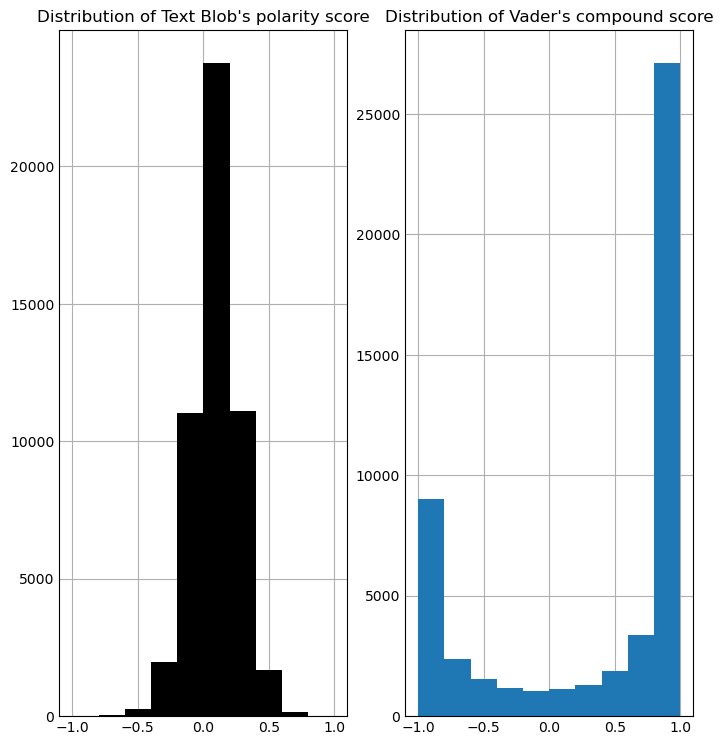

In [41]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(131)
ax.hist(analyzer(x),color="black")
ax.set_title("Distribution of Text Blob's polarity score")
ax = fig.add_subplot(132)
ax.hist(vader_analyzer(x))
ax.set_title("Distribution of Vader's compound score")
plt.show()
